In [1]:
from cluster import *
from load_data import *
from matplotlib import pyplot as plt
import sklearn, torch, random, numpy as np, pickle
from torch.nn import ModuleList, functional as F
from sklearn.model_selection import train_test_split
from torch import nn, optim
from os.path import isfile
from sklearn.linear_model import LinearRegression

seed_num = 1
torch.manual_seed(seed_num)
np.random.seed(seed_num) #also sets sklearn seed
random.seed(seed_num)

In [2]:
file = '../Data/stations.dat'
if not isfile(file):
    save_stations(file)
station_id, coord, groups = cluster(file)
coord = np.array(coord)

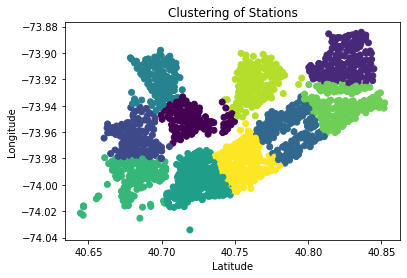

In [3]:
plt.scatter(coord[:, 0], coord[:, 1], c=groups)
plt.title('Clustering of Stations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.savefig('../Graphs/Cluster.png')
plt.show()

In [4]:
class NN(nn.Module):
    def __init__(self, in_width, out_width, layer_widths):
        super(NN, self).__init__()
        self.layers = ModuleList()
        self.decoding = ModuleList()
        self.layers.append(nn.Linear(in_width, layer_widths[0]))
        for i in range(1, len(layer_widths)):
            self.layers.append(nn.Linear(layer_widths[i - 1], layer_widths[i]))
        self.layers.append(nn.Linear(layer_widths[-1], out_width))
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.weight)
        self.optimizer = optim.Adam(self.parameters())
        self.mse = nn.MSELoss()

    def loss_f(self, prediction, target):
        loss = 0
        for i in range(len(prediction)):
            loss += self.mse(prediction[i], target[i])
        return loss
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = nn.ReLU()(x)
        x = self.layers[-1](x)
        return x
        
    def learn(self, train, validation,*, intervals=1000, epochs=100000):
        epochs = tqdm_notebook(range(epochs))
        min_val_loss = float('inf')
        for epoch in epochs:
            self.zero_grad()

            predictions = self(train[0])
            loss = self.loss_f(predictions, train[1])
            if epoch % 10000 == 0:
                print(loss)
            if epoch % intervals == 0:
                val_predictions = self(validation[0])
                
                val_loss = self.loss_f(val_predictions, validation[1])
                min_val_loss = min(min_val_loss, val_loss)
                print(val_loss/min_val_loss)
                if val_loss > min_val_loss * 1.05 and epoch > 10000:
                    break
            loss.backward()
            self.optimizer.step()
        print(f'Ended at epoch {epoch} with loss of {val_loss}\n{val_loss/min_val_loss}')


In [5]:
file = '../Data/data.dat'
if isfile(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
else:
    data = load({station_id[i]: groups[i] for i in range(len(station_id))}, file)

In [6]:
x, y, y2 = data
x, y, y2 = torch.tensor(x).float(), torch.tensor(y).float(), torch.tensor(y2).float()
x_train, x_test, y_train, y_test, y2_train, y2_test = train_test_split(x, y, y2)
x_train, x_val, y_train, y_val, y2_train, y2_val = train_test_split(x_train, y_train, y2_train)

repair = NN(len(x_train[0]), len(y_train[0]), [10]*30)
file = '../Data/repair.pt'
if isfile(file):
    repair.load_state_dict(torch.load(file))
    repair.eval()
else:
    repair.learn((x_train, y_train), (x_val, y_val))
    torch.save(repair.state_dict(), file)  

demand = NN(len(x_train[0]), len(y2_train[0]), [10]*30)
file = '../Data/demand.pt'
if isfile(file):
    demand.load_state_dict(torch.load(file))
    demand.eval()
else:
    demand.learn((x_train, y2_train), (x_val, y2_val), epochs=500000)
    torch.save(demand.state_dict(), file)  

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor(1.0605e+10, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1.4563, grad_fn=<DivBackward0>)
tensor(1.0494, grad_fn=<DivBackward0>)
tensor(1.0880, grad_fn=<DivBackward0>)
tensor(1.1453, grad_fn=<DivBackward0>)
tensor(1.1266, grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(9.4490e+08, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1.0949, grad_fn=<DivBackward0>)
Ended at epoch 12000 with loss of 166024496.0
1.094946265220642


  0%|          | 0/500000 [00:00<?, ?it/s]

tensor(6.3847e+08, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1.0057, grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(0.0398, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1., grad_fn=<DivBackward0>)
tensor(1.1466, grad_fn=<DivBackward0>)
Ended at epoch 15000 with loss of 17.87668228149414
1.1466078758239746


In [7]:
repair_linear = LinearRegression().fit(x_train, y_train)
prediction = torch.tensor(repair_linear.predict(x_test))

print(repair.loss_f(prediction, y_test))

prediction = repair(x_test)
print(repair.loss_f(prediction, y_test))

class MultiOutputLinear:
    def __init__(self):
        self.models = []
    def fit(self, x, y):
        y = y.numpy()
        for i in range(len(y[0])):
            self.models.append(LinearRegression().fit(x, y[:, i]))
    def predict(self, x):
        out = []
        for i in self.models:
            out.append(i.predict(x))
        out = np.array(out)
        out = out.transpose()
        return out

demand_linear = MultiOutputLinear()
demand_linear.fit(x_train, y2_train)
prediction = torch.tensor(demand_linear.predict(x_test))
print(demand.loss_f(prediction, y2_test))
prediction1 = demand(x_test)
print(demand.loss_f(prediction1, y2_test))

tensor(1.3026e+08)
tensor(5.4409e+08, grad_fn=<AddBackward0>)
tensor(0.0015)
tensor(0.6979, grad_fn=<AddBackward0>)
